In [22]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

os              : Linux-6.8.0-38-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [23]:
df = load_object("preprocessed_data/dataframes/solfsmy.pkl")
model_data = torch.load("models/best_model.pth")
data_columns = ['F10', 'S10', 'M10', 'Y10']

lookback = model_data['lookback']
horizon = model_data['horizon']
models = model_data['models']

In [24]:
lookback_data = df[['F10', 'S10', 'M10', 'Y10']].iloc[-42:-6]

X_forecast = torch.tensor(lookback_data.values.T).float().unsqueeze(0).to(device)
X_forecast.shape

torch.Size([1, 4, 36])

In [25]:
with torch.no_grad():
    predictions = []
    for model in models:
        model.eval()
        predictions.append(model(X_forecast))
        predictions = torch.stack(predictions, dim=0)

        predictions = predictions.mean(dim=0)



preds_df = pd.DataFrame(predictions.squeeze(0).T, columns=data_columns)
true_df = df[df.Date > df.Date.max()-pd.DateOffset(days=6)]

In [26]:
def plot_predictions_performance(true_df, preds_df):
    """
    Plot the performance of the predictions compared to the true values.
    
    Parameters
    ----------
    true_df : pd.DataFrame
        DataFrame containing the true values.
    preds_df : pd.DataFrame
        DataFrame containing the predicted values
    """
    true_df = true_df.copy()
    preds_df = preds_df.copy()

    # Align preds_df with true_df by setting Date as index in true_df
    true_df.set_index('Date', inplace=True)

    # Assuming preds_df has the same index as true_df (if not, align them accordingly)
    preds_df.index = true_df.index

    # Number of columns to plot
    num_columns = len(preds_df.columns)
    num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed

    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows), sharex=True)
    axes = axes.flatten()  # Flatten in case there is a single row

    # Plot each column
    for i, column in enumerate(preds_df.columns):
        ax = axes[i]
        
        # Plot true values with points
        ax.plot(true_df.index, true_df[column], label='True', color='black', marker='o')
        
        # Plot predicted values with points
        ax.plot(preds_df.index, preds_df[column], label='Predicted', color='green', marker='o')
        
        # Add ribbon
        overestimate = preds_df[column] > true_df[column]
        underestimate = preds_df[column] <= true_df[column]
        
        ax.fill_between(preds_df.index, true_df[column], preds_df[column],
                        where=overestimate, facecolor='red', alpha=0.2, interpolate=True, label='Overestimated')
        ax.fill_between(preds_df.index, true_df[column], preds_df[column],
                        where=underestimate, facecolor='blue', alpha=0.2, interpolate=True, label='Underestimated')
        
        # Annotate points with values
        for x, y in zip(true_df.index, true_df[column]):
            ax.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)
        for x, y in zip(preds_df.index, preds_df[column]):
            ax.annotate(f'{y:.1f}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)

        ax.set_title(f'Comparison of true and predicted values for {column}')
        ax.set_ylabel('SFU')
        ax.legend()

    # Apply date formatting to the bottom subplots
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=12))  # Locate dates at 12:00:00
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y (%a)'))
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right',rotation=30)


    plt.show()

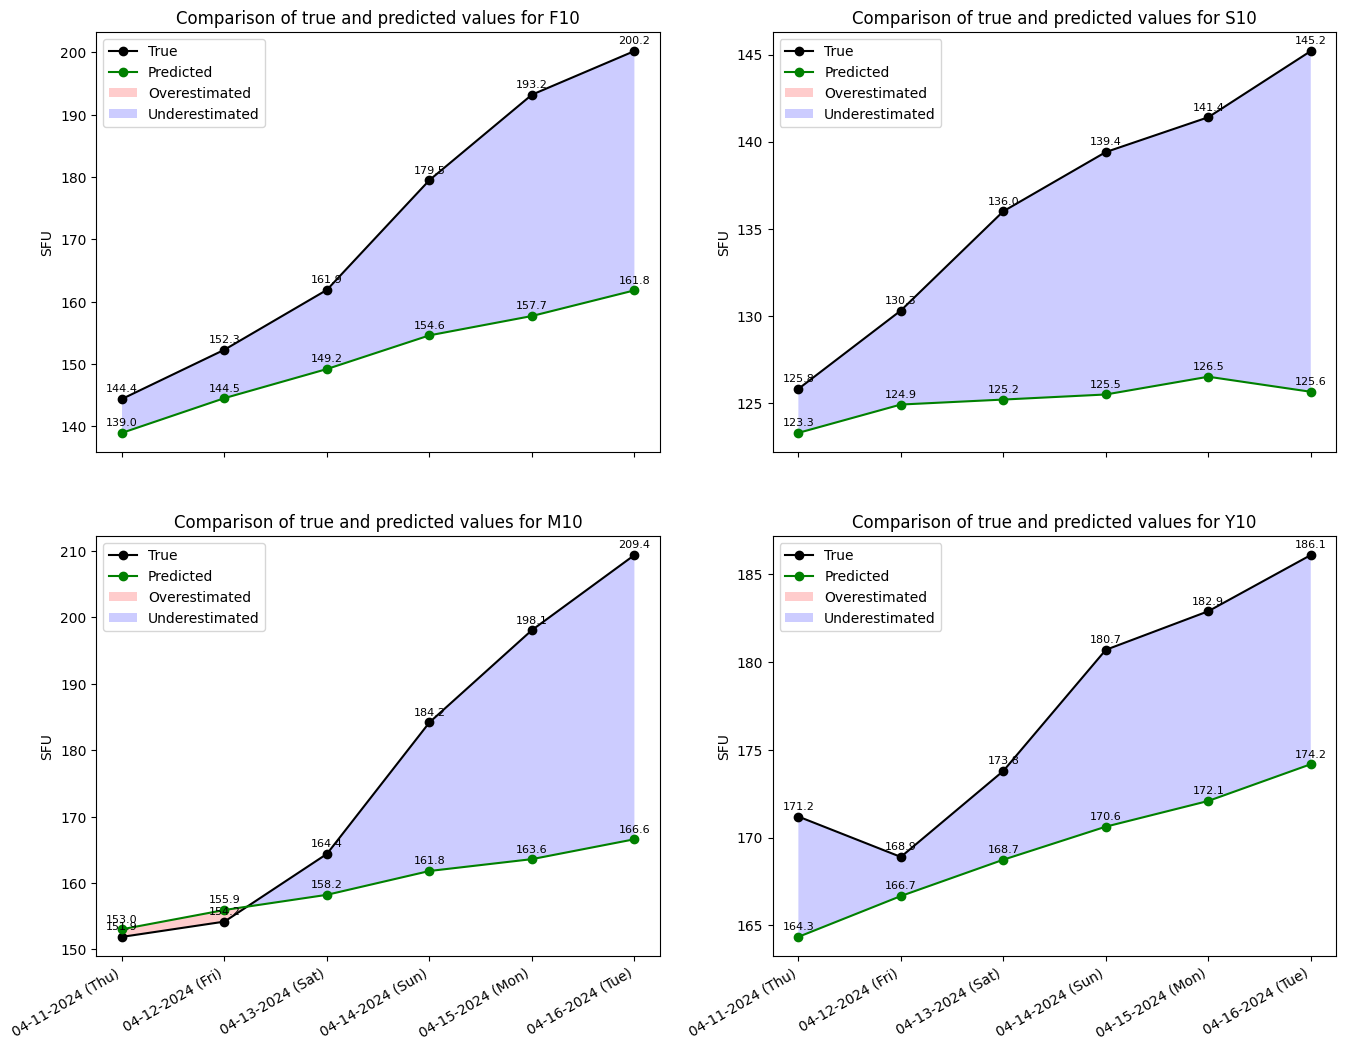

In [27]:
plot_predictions_performance(true_df, preds_df)

Timestamp('2024-04-16 12:00:00')

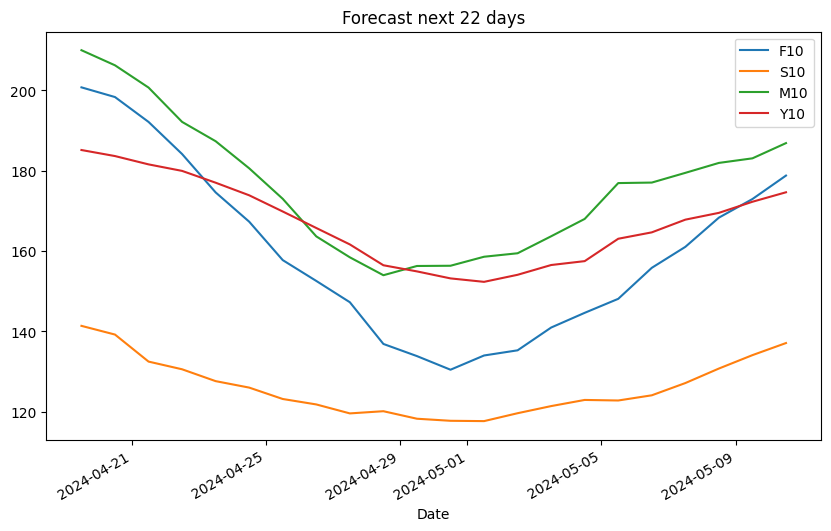

In [28]:
days_to_forecast = 22
to_forecast_df = df.iloc[-36:]

def recurent_forecasting(df, days_to_forecast=12):
    to_forecast_df = df.copy()
    forecasted_days = 0

    while forecasted_days < days_to_forecast:
        lookback_data = to_forecast_df[['F10', 'S10', 'M10', 'Y10']].iloc[-36:]

        X_forecast = torch.tensor(lookback_data.values.T).float().unsqueeze(0).to(device)

        with torch.no_grad():
            predictions = model(X_forecast)

        dates = [to_forecast_df.Date.max() + dt.timedelta(days=j) for j in range(1, 7)]
        pred_df = pd.DataFrame(predictions.squeeze(0).T, columns=['F10', 'S10', 'M10', 'Y10'])
        pred_df['Date'] = dates
        to_forecast_df = pd.concat([to_forecast_df, pred_df], axis=0, ignore_index=True).reset_index(drop=True)
        
        forecasted_days += len(dates)
    
    return to_forecast_df

forecasts = recurent_forecasting(to_forecast_df, days_to_forecast)
forecasts.iloc[-days_to_forecast:].plot(x='Date', y=['F10', 'S10', 'M10', 'Y10'], figsize=(10, 6), title=f'Forecast next {days_to_forecast} days')
    


df.Date.max()

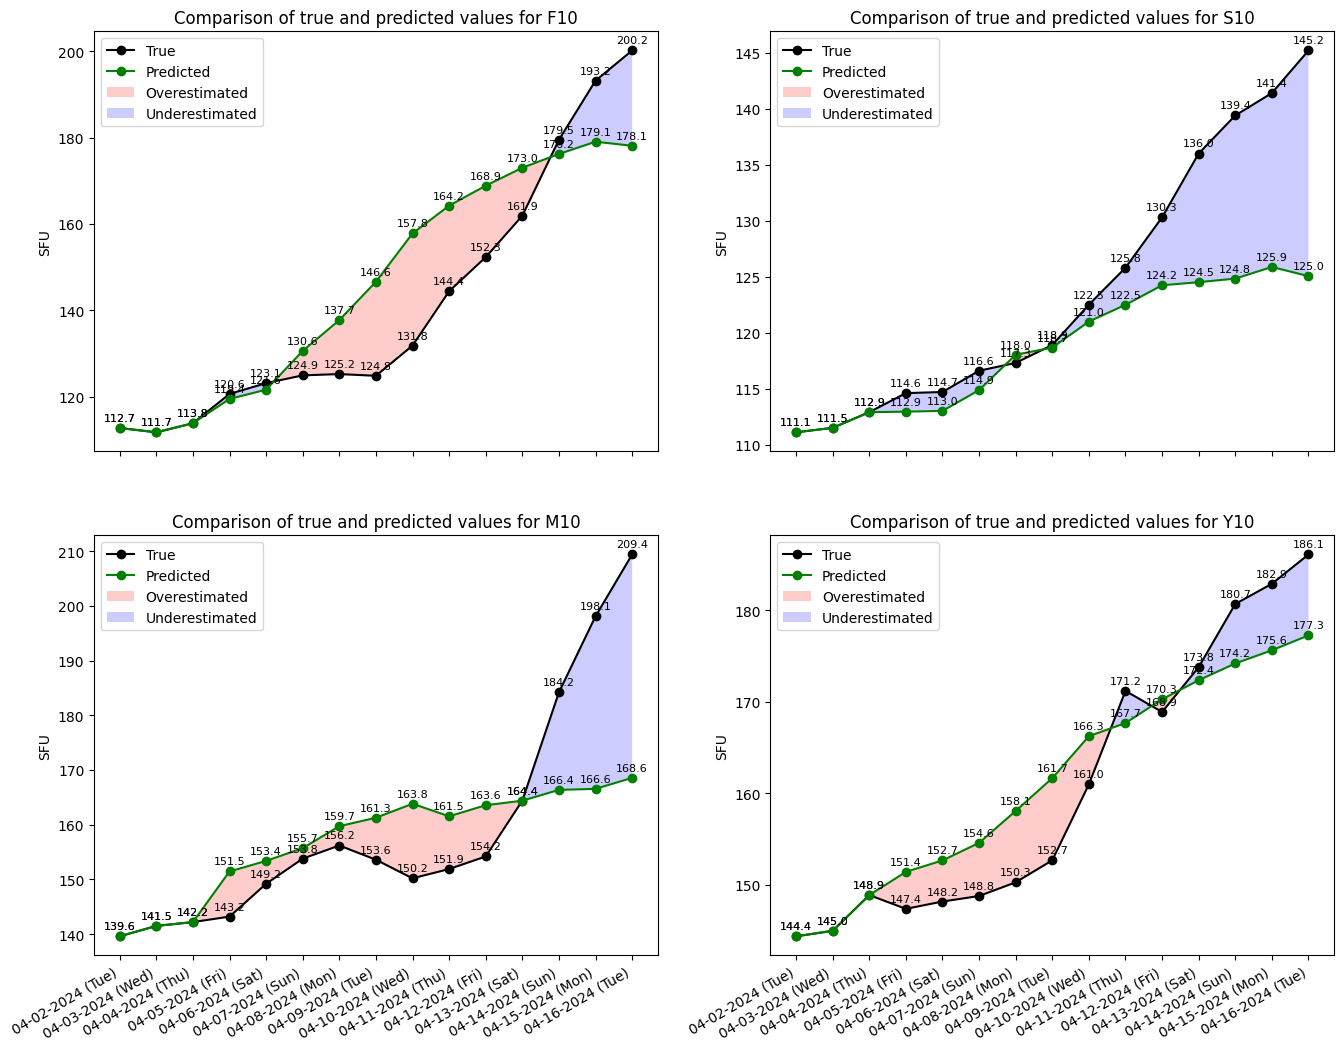

In [29]:
days_to_forecast = 12

to_forecast_df = df.iloc[-(36+days_to_forecast):-days_to_forecast]

preds_df = recurent_forecasting(to_forecast_df, days_to_forecast)[data_columns].iloc[-(days_to_forecast+3):]
true_df = df[data_columns + ['Date']].iloc[-(days_to_forecast + 3):]
plot_predictions_performance(true_df, preds_df)